# Load dependences

In [23]:
import pandas as pd
import os
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from copy import deepcopy
from rdkit import Chem
from rdkit.Chem import Draw
select_seed = 1
hl_seed = 5
repeat_time = 5
%matplotlib notebook
n_jobs = ! cat /proc/cpuinfo | grep "processor" | sort | uniq | wc -l
n_jobs = eval(n_jobs[0])
print('max available CPU thread is: %d, we will use the max thread defaultly'%n_jobs)

max available CPU thread is: 64, we will use the max thread defaultly


# Load data

The availability of  *\"full_dataset.csv\"* will provide at http://asymcatml.net after this paper is online.

In [ ]:
if not os.path.exists('./hierarchical_learning/hl_desc.zip'):
    ! wget http://spmsgen.net:8000/download/hl_desc.zip
    ! unzip ./hl_desc.zip
    ! mv hl_desc.zip ./hierarchical_learning/
    ! mv ./hl_desc/react_mf.npy ./hierarchical_learning/
    ! mv ./hl_desc/react_mbtr.npy ./hierarchical_learning/

In [3]:
database_df = pd.read_csv('./full_dataset.csv',index_col=0)      ### The availability of "full_dataset.csv" will provide 
                                                                 ### at http://asymcatml.net after this paper is online.
lig_smi = database_df['Ligand SMILES'].to_numpy()
cat_smi = database_df['Catalyst SMILES(RDKit)'].to_numpy()
re_smi = database_df['Reactant SMILES'].to_numpy()
pr_smi = database_df['Product SMILES'].to_numpy()
sol_smi = database_df['Solvent SMILES'].to_numpy()
metals = database_df['Metal'].to_numpy()
temp = database_df['Temperature/C'].to_numpy()
s_c = database_df['S/C'].to_numpy()
press = database_df['Pressure/atm'].to_numpy()
ee = database_df['ee'].to_numpy()
ddG = database_df['ddG'].to_numpy()
react_fp = np.load('./hierarchical_learning/react_mf.npy')
react_mbtr = np.load('./hierarchical_learning/react_mbtr.npy')
react_desc = np.concatenate([react_fp,react_mbtr],axis=1)
react_fp = 0
react_mbtr = 0
ddG_std = (ddG - ddG.min())/(ddG.max()-ddG.min())

In [4]:
np.random.seed(9)
target_set_index = []
ddG_distrib_dict = {0.1:[],0.2:[],0.3:[],0.4:[],
                   0.5:[],0.6:[],0.7:[],0.8:[],
                   0.9:[],1.0:[]}
shuffle_idx = list(range(len(lig_smi)))
np.random.shuffle(shuffle_idx)
print('Select related data and target set.')
for i in shuffle_idx:
    if re_smi[i] == 'COC(=O)/C(=C/c1ccccc1)NC(C)=O' and metals[i] == 'Rh':
        if temp[i] >= 20 and temp[i] <= 30:
            if ddG_std[i] <= 0.1 and len(ddG_distrib_dict[0.1]) < 10:
                ddG_distrib_dict[0.1].append(ddG_std[i])
                target_set_index.append(i)
            elif ddG_std[i] <= 0.2 and ddG_std[i] > 0.1 and len(ddG_distrib_dict[0.2]) < 10:
                ddG_distrib_dict[0.2].append(ddG_std[i])
                target_set_index.append(i)
            elif ddG_std[i] <= 0.3 and ddG_std[i] > 0.2 and len(ddG_distrib_dict[0.3]) < 10:
                ddG_distrib_dict[0.3].append(ddG_std[i])
                target_set_index.append(i)
            elif ddG_std[i] <= 0.4 and ddG_std[i] > 0.3 and len(ddG_distrib_dict[0.4]) < 10:
                ddG_distrib_dict[0.4].append(ddG_std[i])
                target_set_index.append(i)
            elif ddG_std[i] <= 0.5 and ddG_std[i] > 0.4 and len(ddG_distrib_dict[0.5]) < 10:
                ddG_distrib_dict[0.5].append(ddG_std[i])
                target_set_index.append(i)
            elif ddG_std[i] <= 0.6 and ddG_std[i] > 0.5 and len(ddG_distrib_dict[0.6]) < 10:
                ddG_distrib_dict[0.6].append(ddG_std[i])
                target_set_index.append(i)
            elif ddG_std[i] <= 0.7 and ddG_std[i] > 0.6 and len(ddG_distrib_dict[0.7]) < 10:
                ddG_distrib_dict[0.7].append(ddG_std[i])
                target_set_index.append(i)
            elif ddG_std[i] <= 0.8 and ddG_std[i] > 0.7 and len(ddG_distrib_dict[0.8]) < 10:
                ddG_distrib_dict[0.8].append(ddG_std[i])
                target_set_index.append(i)
            elif ddG_std[i] <= 0.9 and ddG_std[i] > 0.8 and len(ddG_distrib_dict[0.9]) < 10:
                ddG_distrib_dict[0.9].append(ddG_std[i])
                target_set_index.append(i)
            elif ddG_std[i] <= 1.0 and ddG_std[i] > 0.9 and len(ddG_distrib_dict[1.0]) < 10:
                ddG_distrib_dict[1.0].append(ddG_std[i])
                target_set_index.append(i)
related_set_1 = []
related_set_2 = []
shuffle_idx = list(range(len(lig_smi)))
np.random.shuffle(shuffle_idx)
count_1 = 0
count_2 = 0

for i in shuffle_idx:
    if re_smi[i] == 'COC(=O)/C(=C/c1ccccc1)NC(C)=O' or metals[i] != 'Rh':
        continue
    if not Chem.MolFromSmiles(re_smi[i]).HasSubstructMatch(Chem.MolFromSmiles('COC(C(NC(C)=O)=C)=O')) and \
    not Chem.MolFromSmiles(re_smi[i]).HasSubstructMatch(Chem.MolFromSmiles('O=C(/C=C/C1=CC=CC=C1)OC')) and \
    not Chem.MolFromSmiles(re_smi[i]).HasSubstructMatch(Chem.MolFromSmiles('O=C(C)N/C=C\c1ccccc1')) and\
    count_1 < 10000:
        if Chem.MolFromSmiles(re_smi[i]).HasSubstructMatch(Chem.MolFromSmiles('C=CNC(C)=O')) or \
        Chem.MolFromSmiles(re_smi[i]).HasSubstructMatch(Chem.MolFromSmiles('C=Cc1ccccc1')) or \
        Chem.MolFromSmiles(re_smi[i]).HasSubstructMatch(Chem.MolFromSmiles('COC(C=C)=O')):
            related_set_1.append(i)
            count_1 += 1
    elif Chem.MolFromSmiles(re_smi[i]).HasSubstructMatch(Chem.MolFromSmiles('COC(C(NC(C)=O)=C)=O')) or \
         Chem.MolFromSmiles(re_smi[i]).HasSubstructMatch(Chem.MolFromSmiles('O=C(/C=C/C1=CC=CC=C1)OC')) or \
         Chem.MolFromSmiles(re_smi[i]).HasSubstructMatch(Chem.MolFromSmiles('O=C(C)N/C=C\c1ccccc1')):
        if count_2 < 10000:
            related_set_2.append(i)
            count_2 += 1

print('select done!')
print('related set a size: %d, related set b size: %d, target set size: %d'%(
      len(related_set_1),len(related_set_2),len(target_set_index)
      ))
print('number of solvents: %d, number of ligand: %d'%(
          np.unique(sol_smi[target_set_index]).shape[0],
          np.unique(lig_smi[target_set_index]).shape[0]))

Select related data and target set.
select done!
related set a size: 3507, related set b size: 1743, target set size: 86
number of solvents: 12, number of ligand: 61


In [5]:
np.random.seed(1)
target_shuffle_index = list(range(len(target_set_index)))
np.random.shuffle(target_shuffle_index)
target_index_shuffled = np.array(target_set_index)[target_shuffle_index]
test_size = 0.5
target_sub_index = target_index_shuffled[:int(len(target_index_shuffled)*test_size)]
test_index = target_index_shuffled[int(len(target_index_shuffled)*test_size):]

related_set_1_x,related_set_1_y = react_desc[related_set_1],ddG_std[related_set_1]
related_set_2_x,related_set_2_y = react_desc[related_set_2],ddG_std[related_set_2]

target_sub_x,target_sub_y = react_desc[target_sub_index],ddG_std[target_sub_index]
test_x,test_y = react_desc[test_index],ddG_std[test_index]

# Train model

Here, we show how the performance of these three different approaches will be if we just use totally same molecular descriptors (MF+MBTR) and machine learning model (ExtraTrees)

## Hierarchical Learning

In [ ]:
base_model_ens,delta_model_1_ens,delta_model_2_ens = [],[],[]

for rt in range(repeat_time):
    base_model = ExtraTreesRegressor(n_jobs=n_jobs,n_estimators=200,random_state=hl_seed)
    base_model.fit(related_set_1_x,related_set_1_y)
    test_p_hier_1st = base_model.predict(test_x)

    related_set_2_p = base_model.predict(related_set_2_x)
    related_set_2_d = related_set_2_y - related_set_2_p
    delta_model_1 = ExtraTreesRegressor(n_jobs=n_jobs,n_estimators=200,random_state=hl_seed)
    delta_model_1.fit(related_set_2_x,related_set_2_d)
    test_p_hier_2nd = base_model.predict(test_x) + delta_model_1.predict(test_x)

    target_sub_p = base_model.predict(target_sub_x)+delta_model_1.predict(target_sub_x)
    target_sub_d = target_sub_y - target_sub_p
    delta_model_2 = ExtraTreesRegressor(n_jobs=n_jobs,n_estimators=200,random_state=hl_seed)
    delta_model_2.fit(target_sub_x,target_sub_d)
    test_p_hl = delta_model_2.predict(test_x) + delta_model_1.predict(test_x) + base_model.predict(test_x)

    tmp_mae = mean_absolute_error(test_y,test_p_hl)*ddG.max()
    tmp_r2 = r2_score(test_y,test_p_hl)
    
    base_model_ens.append(base_model)
    delta_model_1_ens.append(delta_model_1)
    delta_model_2_ens.append(delta_model_2)
    print('%2d, MAE: %.4f, r2_score: %.4f'%(rt,tmp_mae,tmp_r2))


## Train model with only target substrate set

In [7]:
tag_only_model = ExtraTreesRegressor(n_jobs=n_jobs,n_estimators=200)
tag_only_model.fit(target_sub_x,target_sub_y)
test_p_tag_only = tag_only_model.predict(test_x)

tmp_mae = mean_absolute_error(test_y,test_p_tag_only)*ddG.max()
tmp_r2 = r2_score(test_y,test_p_tag_only)

print('MAE: %.4f, r2_score: %.4f'%(tmp_mae,tmp_r2))

MAE: 0.6187, r2_score: 0.6522


## Train model with related set a, related set b and target substrate set naively

In [8]:
naive_train_x = np.concatenate([related_set_1_x,related_set_2_x,target_sub_x],axis=0)
naive_train_y = np.concatenate([related_set_1_y,related_set_2_y,target_sub_y],axis=0)

naive_model = ExtraTreesRegressor(n_jobs=n_jobs,n_estimators=200)
naive_model.fit(naive_train_x,naive_train_y)
test_p_naive = naive_model.predict(test_x)

tmp_mae = mean_absolute_error(test_y,test_p_naive)*ddG.max()
tmp_r2 = r2_score(test_y,test_p_naive)

print('MAE: %.4f, r2_score: %.4f'%(tmp_mae,tmp_r2))

MAE: 0.5257, r2_score: 0.7301


It can be seen that if using the exact same model and descriptor, the performance of hierarchical learning is better than naively using relevant data extracted from the database. All of them are better than using only a small amount of experimental data. 
 
We can modify parameters of descriptor generation carefully and use more complicated descriptors for target substrate set which is the training set of final hierachy and test set.

## Use more complicated descriptors at final hierachy

For there are just few data in the final hierachy, we can use more complicated descriptors at final hierachy for better model performance
Here, we use more complicated MBTR and MF with larger cutoff radius which could be generated in tuturial 01-generate_descriptors.ipynb

In [9]:
target_index = np.concatenate([target_sub_index,test_index])
target_set_cat = cat_smi[target_index]
target_set_sol = sol_smi[target_index]
target_set_prod = pr_smi[target_index]
target_set_press = press[target_index]
target_set_temp = temp[target_index]
target_set_s_c = s_c[target_index]

In [10]:
prod_desc_map = {'COC(=O)[C@@H](Cc1ccccc1)NC(C)=O':np.array([0]),
                 'COC(=O)[C@H](Cc1ccccc1)NC(C)=O':np.array([1])}
target_prod_desc = np.array([prod_desc_map[tmp_smi] for tmp_smi in target_set_prod])

In [12]:
cat_mf_df = pd.read_csv('./hierarchical_learning/cat_mf_desc.csv')
cat_mbtr_df = pd.read_csv('./hierarchical_learning/cat_mbtr_desc.csv')
sol_desc_df = pd.read_csv('./hierarchical_learning/solvent_physfeat.csv')

In [13]:
cat_mbtr_dict = {cat_mbtr_df.to_numpy()[i][0]:cat_mbtr_df.to_numpy()[i][1:] for i in range(len(cat_mbtr_df.to_numpy()))}
cat_mf_dict = {cat_mf_df.to_numpy()[i][0]:cat_mf_df.to_numpy()[i][1:] for i in range(len(cat_mf_df.to_numpy()))}

In [14]:
target_cat_desc = np.array([np.concatenate([
                                     cat_mbtr_dict[target_set_cat[i]],
                                     cat_mf_dict[target_set_cat[i]]
                                    ]) for i in range(len(target_set_cat))])
target_cat_desc = np.array(target_cat_desc,dtype=np.float32)

In [15]:
sol_desc_dict = {sol_desc_df.to_numpy()[i][1]:sol_desc_df.to_numpy()[i][2:] for i in range(len(sol_desc_df.to_numpy()))}

target_sol_desc = []
for tmp_smi in target_set_sol:
    tmp_split_smi = tmp_smi.split('.')
    ave_desc = []
    for tmp_s in tmp_split_smi:
        ave_desc.append(np.array(sol_desc_dict[tmp_s],dtype=np.float32))
    ave_desc = np.average(ave_desc,axis=0)
    target_sol_desc.append(ave_desc)
target_sol_desc = np.array(target_sol_desc)

In [16]:
target_react = np.concatenate([target_cat_desc,
                              target_prod_desc,
                              target_sol_desc,
                              target_set_press.reshape(-1,1),
                              target_set_temp.reshape(-1,1),target_set_s_c.reshape(-1,1)],axis=1)
target_react = (target_react - target_react.min(axis=0))/(target_react.max(axis=0)-target_react.min(axis=0))

The performance of model trainned with complex descriptors of target substrate set is improved.

In [31]:
idx = 3

new_target_sub_x = target_react[:43]
new_test_x = target_react[43:]

new_delta_model_2 = ExtraTreesRegressor(n_jobs=n_jobs,n_estimators=200,random_state=160)
target_sub_p = base_model_ens[idx].predict(target_sub_x)+delta_model_1_ens[idx].predict(target_sub_x)
target_sub_d = target_sub_y - target_sub_p

new_delta_model_2.fit(new_target_sub_x,target_sub_d)

new_test_p_hl = base_model_ens[idx].predict(test_x)+delta_model_1_ens[idx].predict(test_x)+new_delta_model_2.predict(new_test_x)

tmp_r2 = r2_score(test_y,new_test_p_hl)
tmp_mae = mean_absolute_error(test_y,new_test_p_hl)*ddG.max()

print('MAE: %.4f, r2_score: %.4f'%(tmp_mae,tmp_r2))

MAE: 0.3684, r2_score: 0.8687


The performance of model trainned with only target substrate set is improved.

In [34]:
new_tag_only_model = ExtraTreesRegressor(n_jobs=n_jobs,n_estimators=200)
new_tag_only_model.fit(new_target_sub_x,target_sub_y)
new_test_p_tag_only = new_tag_only_model.predict(new_test_x)
tmp_r2 = r2_score(test_y,new_test_p_tag_only)
tmp_mae = mean_absolute_error(test_y,new_test_p_tag_only)*ddG.max()
print('R2: %.4f, MAE: %.4f'%(tmp_r2,tmp_mae))

R2: 0.6842, MAE: 0.5730


# Visualization of the ML result

The figure below shows that the performance of three different approaches when handle with few-shot learning problem

<IPython.core.display.Javascript object>


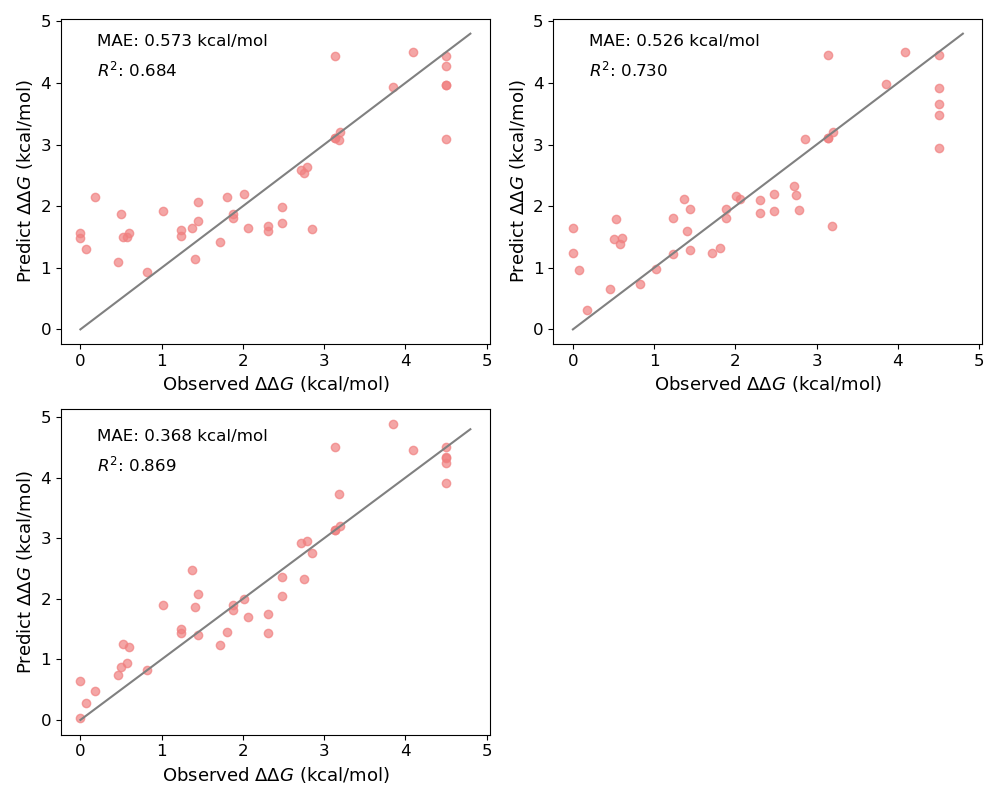

In [35]:
fig = plt.figure(figsize=(10,8))
label_font_size = 13
title_fontsize = 15
ticks_font_size = 12

plt.subplot(221)
plt.scatter(test_y*ddG.max(),new_test_p_tag_only*ddG.max(),c='lightcoral',alpha=0.7)
plt.xlabel('Observed $\Delta$$\Delta$$\itG$ (kcal/mol)',fontsize=label_font_size)
plt.ylabel('Predict $\Delta$$\Delta$$\itG$ (kcal/mol)',fontsize=label_font_size)
plt.text(0.2,4.6,'MAE: %.3f kcal/mol'%mean_absolute_error(test_y*ddG.max(),new_test_p_tag_only*ddG.max()),fontsize=ticks_font_size)
plt.text(0.2,4.1,'${R^2}$: %.3f'%r2_score(test_y*ddG.max(),new_test_p_tag_only*ddG.max()),fontsize=ticks_font_size)
plt.plot([0,4.8],[0,4.8],color='grey')
plt.xticks(fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)

plt.subplot(222)
plt.scatter(test_y*ddG.max(),test_p_naive*ddG.max(),c='lightcoral',alpha=0.7)
plt.xlabel('Observed $\Delta$$\Delta$$\itG$ (kcal/mol)',fontsize=label_font_size)
plt.ylabel('Predict $\Delta$$\Delta$$\itG$ (kcal/mol)',fontsize=label_font_size)
plt.text(0.2,4.6,'MAE: %.3f kcal/mol'%mean_absolute_error(test_y*ddG.max(),test_p_naive*ddG.max()),fontsize=ticks_font_size)
plt.text(0.2,4.1,'${R^2}$: %.3f'%r2_score(test_y*ddG.max(),test_p_naive*ddG.max()),fontsize=ticks_font_size)
plt.plot([0,4.8],[0,4.8],color='grey')
plt.xticks(fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)

plt.subplot(223)
plt.scatter(test_y*ddG.max(),new_test_p_hl*ddG.max(),c='lightcoral',alpha=0.7)
plt.xlabel('Observed $\Delta$$\Delta$$\itG$ (kcal/mol)',fontsize=label_font_size)
plt.ylabel('Predict $\Delta$$\Delta$$\itG$ (kcal/mol)',fontsize=label_font_size)
plt.text(0.2,4.6,'MAE: %.3f kcal/mol'%mean_absolute_error(test_y*ddG.max(),new_test_p_hl*ddG.max()),fontsize=ticks_font_size)
plt.text(0.2,4.1,'${R^2}$: %.3f'%r2_score(test_y*ddG.max(),new_test_p_hl*ddG.max()),fontsize=ticks_font_size)
plt.plot([0,4.8],[0,4.8],color='grey')
plt.xticks(fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)


plt.tight_layout()


The figure below shows that the prediction error of three hierarchies in hierarchical learning approach

<IPython.core.display.Javascript object>


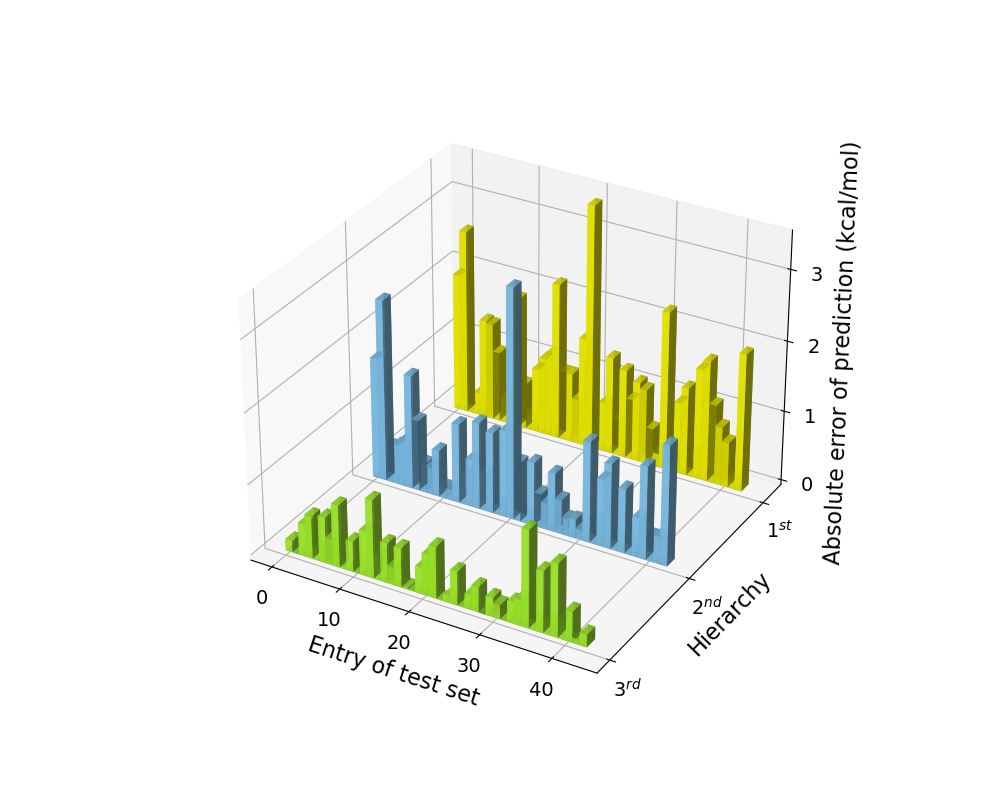

Text(0.5, 0, 'Absolute error of prediction (kcal/mol)')

In [36]:
label_size = 16
tick_size = 14
title_fontsize = 18
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')

dev_1  =(test_p_hier_1st-test_y)*ddG.max()
dev_2 = (test_p_hier_2nd-test_y)*ddG.max()
dev_3 = (new_test_p_hl-test_y)*ddG.max()

shuffle_index = list(range(len(dev_1)))
np.random.shuffle(shuffle_index)
dev_1 = dev_1[shuffle_index]
dev_2 = dev_2[shuffle_index]
dev_3 = dev_3[shuffle_index]

x = list(range(len(dev_1)))

ax1.bar3d(x,np.zeros(len(x))+2,np.zeros(len(x)),1,0.1,np.abs(dev_1),shade=True,color='yellow',alpha=0.8)
ax1.bar3d(x,np.zeros(len(x))+1,np.zeros(len(x)),1,0.1,np.abs(dev_2),shade=True,color='lightskyblue',alpha=0.8)
ax1.bar3d(x,np.zeros(len(x))+0,np.zeros(len(x)),1,0.1,np.abs(dev_3), shade=True,color='greenyellow',alpha=0.8)

ax1.set_xticks([0,10,20,30,40])
ax1.set_xticklabels(['0','10','20','30','40'],fontsize=tick_size)

ax1.set_yticks([0,1,2])
ax1.set_yticklabels(['${3^{rd}}$','${2^{nd}}$','${1^{st}}$'],fontsize=tick_size)

ax1.set_zticks([0,1,2,3])
ax1.set_zticklabels(['0','1','2','3'],fontsize=tick_size)
ax1.set_xlabel('Entry of test set',fontsize=label_size,labelpad=8)
ax1.set_ylabel('Hierarchy',fontsize=label_size)
ax1.set_zlabel('Absolute error of prediction (kcal/mol)',fontsize=label_size)
